In [1]:
import glob
import sys
import numpy as np

In [3]:
emission_files = sorted(glob.glob("../data/Figure3_Supplement/*/emission*"))
arg_files      = sorted(glob.glob("../data/Figure3_Supplement/*/args.json"))

len(arg_files), len(emission_files)

(42, 42)

In [3]:
import itertools

keys = ['position', 'velocity', 'direction']
options = list(itertools.product(keys, ['original', 'shuffle']))
options = np.array(options).reshape(3,2,2).transpose(1,0,2).reshape(6, 2).tolist()
options = list(map(tuple, options))
print(options)

import pandas as pd

def rep(k):
  if len(k) == 0:
    return "none"
  if len(k) == 2:
    return "none"
  return k.pop()

args = []
for selection in itertools.product(options, options):
  kwargs = {opt : set() for opt in keys}
  for k,v in selection:
    kwargs[k].add(v)
  args.append({
    "src" : tuple(selection[0]),
    "tgt" : tuple(selection[1]),
    "config": tuple(rep(kwargs[k]) for k in keys)
  })
  
df = pd.DataFrame(args).pivot("src", "tgt")
df.iloc[[0,2,4,1,3,5],[0,2,4,1,3,5]]

[('position', 'original'), ('velocity', 'original'), ('direction', 'original'), ('position', 'shuffle'), ('velocity', 'shuffle'), ('direction', 'shuffle')]


config                              \
tgt                         (direction, original)        (position, original)   
src                                                                             
(direction, original)      (none, none, original)  (original, none, original)   
(position, original)   (original, none, original)      (original, none, none)   
(velocity, original)   (none, original, original)  (original, original, none)   
(direction, shuffle)           (none, none, none)   (original, none, shuffle)   
(position, shuffle)     (shuffle, none, original)          (none, none, none)   
(velocity, shuffle)     (none, shuffle, original)   (original, shuffle, none)   

                                                                              \
tgt                          (velocity, original)       (direction, shuffle)   
src                                                                            
(direction, original)  (none, original, original)         (none, none, none)   
(position, original)   (original, original, none)  (original, none, shuffle)   
(velocity, original)       (none, original, none)  (none, original, shuffle)   
(direction, shuffle)    (none, original, shuffle)      (none, none, shuffle)   
(position, shuffle)     (shuffle, original, none)   (shuffle, none, shuffle)   
(velocity, shuffle)            (none, none, none)   (none, shuffle, shuffle)   

                                                                             
tgt                          (position, shuffle)        (velocity, shuffle)  
src                                                                          
(direction, original)  (shuffle, none, original)  (none, shuffle, original)  
(position, original)          (none, none, none)  (original, shuffle, none)  
(velocity, original)   (shuffle, original, none)         (none, none, none)  
(direction, shuffle)    (shuffle, none, shuffle)   (none, shuffle, shuffle)  
(position, shuffle)        (shuffle, none, none)   (shuffle, shuffle, none)  
(velocity, shuffle)     (shuffle, shuffle, none)      (none, shuffle, none)

In [ ]:
# package dataset

DATADIR='/home/stes/projects/neural_cl/cebra_public/data'
dataset = cebra.datasets.init("rat-hippocampus-achilles-split", root = DATADIR)

In [10]:
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns


velocity = scipy.signal.savgol_filter(dataset.index[:,0], window_length=31, polyorder=2, deriv=1)
accel = scipy.signal.savgol_filter(dataset.index[:,0], window_length=11, polyorder=2, deriv=2)

fig, axes = plt.subplots(3,1,figsize = (12, 3),sharex = True, dpi = 150)
axes[0].plot(dataset.index[:, 0], c = 'k')
axes[0].set_ylim([-0.05, 1.65])
axes[0].set_yticks([0, 1.6])
axes[0].set_yticklabels([0, 1.6])

axes[1].plot(velocity, c = 'k')
axes[2].plot(dataset.index[:, 1] - dataset.index[:, 2], c = 'k')

for i, ax in enumerate(axes):
  sns.despine(ax=ax, trim = True, bottom = i != 2)
for ax, lbl in zip(axes, ['pos', 'vel', 'dir']):
  ax.set_ylabel(lbl)
  
plt.show()

plt.figure(figsize = (3, 3), dpi = 150)
plt.plot(
  dataset.index[:, 0],
  velocity,
  linewidth = .5,
  color = 'black',
  alpha = .8
)
plt.xlabel("position")
plt.ylabel("velocity")
sns.despine(trim = True)
plt.show()

NameError: name 'cebra' is not defined

In [210]:
import numpy as np
import torch
import json

def load_emission(path, which):
  emission = torch.load(path)
  return emission[which]

def load_loss(path):
  emission = torch.load(path, map_location = "cpu")
  return emission['loss']

def load_args(path):
  with open(path, "r") as fh:
    idx = [5,7,9,-1]
    args = json.load(fh)
    position, velocity, direction, loader = [args['data'].split("-")[i] for i in idx]
    args['direction'] = direction
    args['velocity'] = velocity
    args['position'] = position
    args['loader'] = loader
    return args, (position, velocity, direction,loader,args['num_output'])

losses = [load_emission(e, 'losses') for e in emission_files]
emissions = [load_emission(e, 'train') for e in emission_files]
emissions_test = [load_emission(e, 'test') for e in emission_files]
args = [load_args(path) for path in arg_files]
files = {keys + ('train',) : values for (_,keys), values in zip(args, emissions)}
files.update({keys + ('test',) : values for (_,keys), values in zip(args, emissions_test)})
files.update({keys + ('loss',) : values for (_,keys), values in zip(args, losses)})

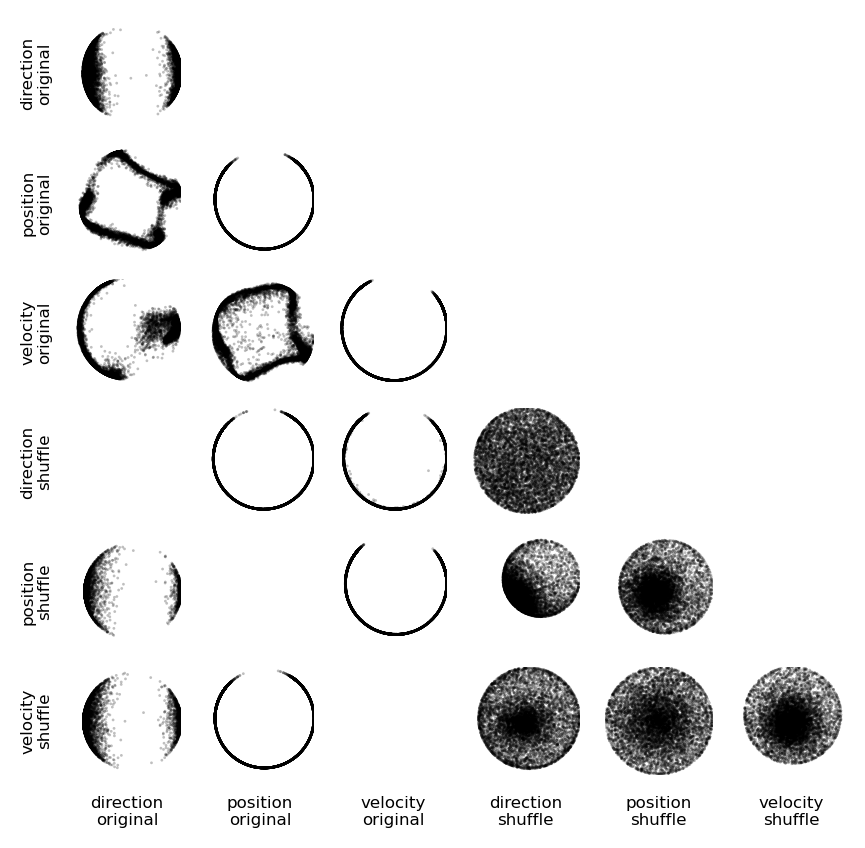

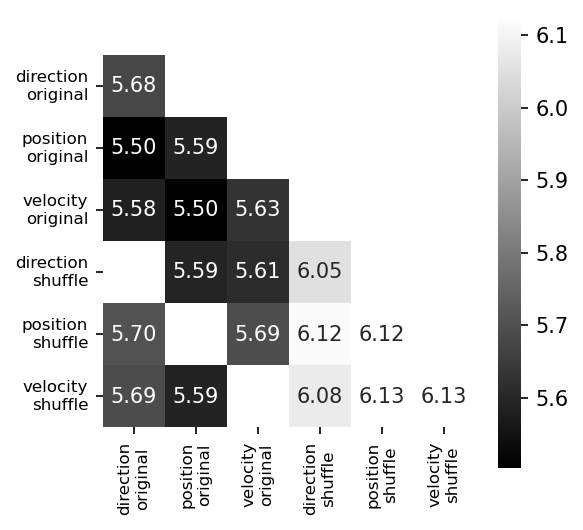

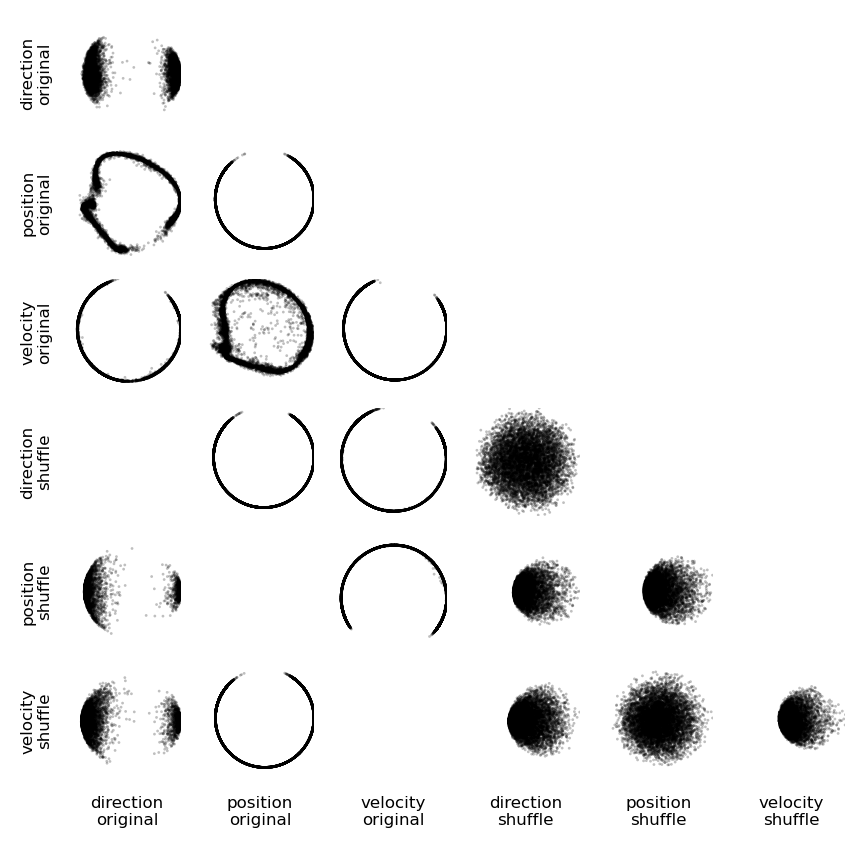

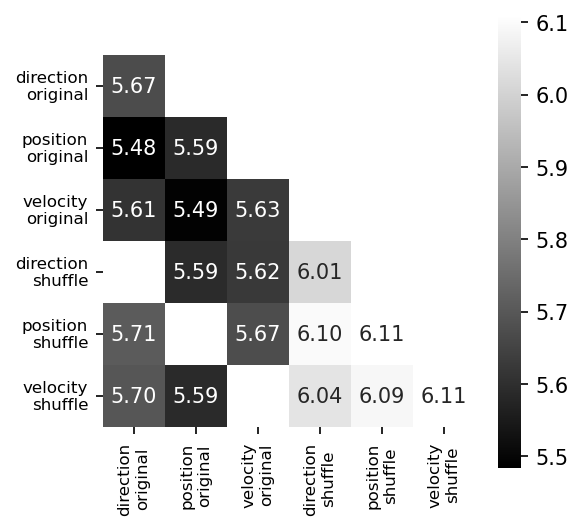

In [215]:
from sklearn.decomposition import PCA

def scatter(data, ax):
  
  pca = PCA(2, whiten = False)
  pca.fit(data)
  data = pca.transform(data)[:, :]
  data /= data.max(keepdims = True)
  x,y = data[:, :2].T
  
  ax.scatter(x, y, s = 1, alpha = .25, edgecolor = 'none', c = 'k') #, c = f"C{n}")

def apply_style(ax):
    sns.despine(ax = ax, trim = True, left = True, bottom = True)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_aspect('equal')

    
def scatter_grid(df, dim):
  fig, axes = plt.subplots(6, 6, figsize = (5, 5), dpi = 200)
  
  df = df.iloc[[0,2,4,1,3,5],[0,2,4,1,3,5]]

  for i, (index, row) in enumerate(zip(df.index, axes)):  
    for j, (column, ax) in enumerate(zip(df.columns, row)):
      apply_style(ax)
      if i == 5:
        ax.set_xlabel('{}\n{}'.format(*column[1]), fontsize = 6)
      if j == 0:
        ax.set_ylabel('{}\n{}'.format(*index), fontsize = 6)
      if j > i:
        continue
      entry = df[column][index]
      key = entry + ("continuous", dim, "train")
      if entry == ("none", "none", "none"):
        continue
      emission = files[key]

      scatter(emission[:, :], ax = ax) 

def plot_heatmap(df, dim):
  
  def to_heatmap(entry):
    key = entry + ("continuous", dim, "loss")
    return min(files.get(key, [float("nan")]))

  df = df.iloc[[0,2,4,1,3,5],[0,2,4,1,3,5]]
  labels = ['{}\n{}'.format(*i) for i in df.index]
  hm = df.applymap(to_heatmap)
  for i, j in itertools.product(range(len(hm)), range(len(hm))):
    if j > i:
      hm.iloc[i, j] = float("nan")

  plt.figure(figsize = (4, 4), dpi = 150)
  sns.heatmap(hm, cmap = 'gray', xticklabels=labels, yticklabels=labels, annot = True, fmt=".2f", square=True)
  plt.xlabel("")
  plt.ylabel("")
  plt.gca().set_xticklabels(labels, fontsize = 8)
  plt.gca().set_yticklabels(labels, fontsize = 8)
  plt.show()
  
scatter_grid(df, 3)
plot_heatmap(df, 3)

scatter_grid(df, 8)
plot_heatmap(df, 8)

In [222]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

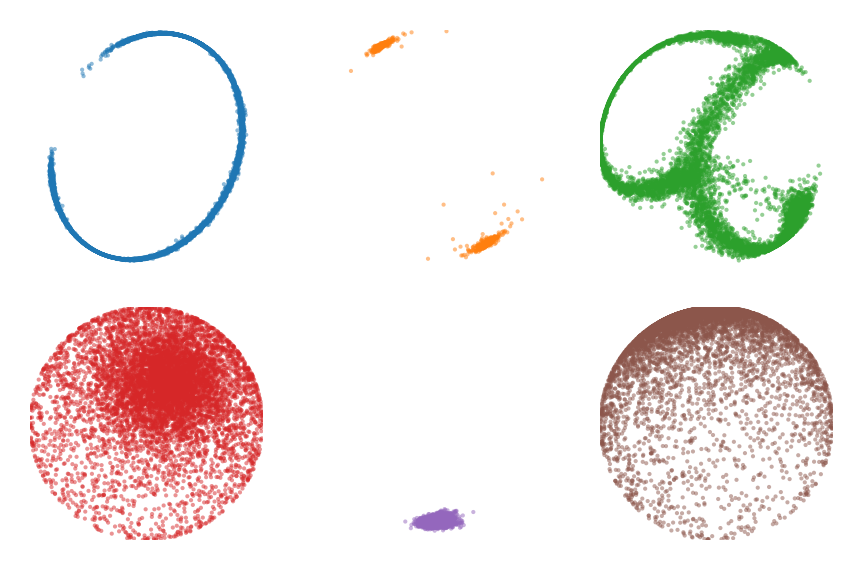

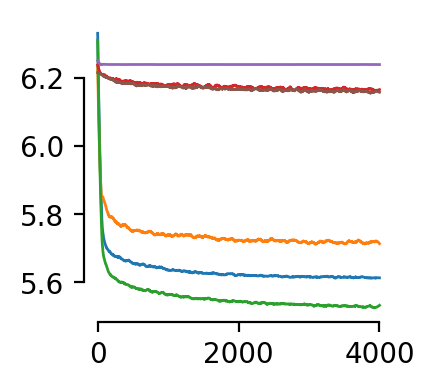

In [110]:
from scipy.signal import savgol_filter

def loss_curve_plot(keys):
  fig, axes = plt.subplots(1, 1, figsize = (2, 2), dpi = 200)
  for key in keys:
    key = key[:-1] + ('loss',)
    loss = files[key]
    plt.plot(savgol_filter(loss, window_length=101, polyorder=2), linewidth = 1)
  sns.despine(trim = True)
  plt.show()

keys = [
 ('none', 'original', 'continuous', 3, 'train'),
 ('original', 'none', 'discrete', 3, 'train'),
 ('original', 'original', 'continuous', 3, 'train'),  
  
 ('none', 'shuffle', 'continuous', 3, 'train'),
 ('shuffle', 'none', 'discrete', 3, 'train'),
 ('shuffle', 'shuffle', 'continuous', 3, 'train')
]

n = 0
fig, axes = plt.subplots(2, 3, figsize = (3, 2), dpi = 300)
for ax, key in zip(axes.flatten(), keys):
    emission = files[key]
    scatter(*emission[:, [1,2]].T, ax = ax)
    apply_style(ax)
plt.tight_layout()
plt.show()

loss_curve_plot(keys)
plt.show()

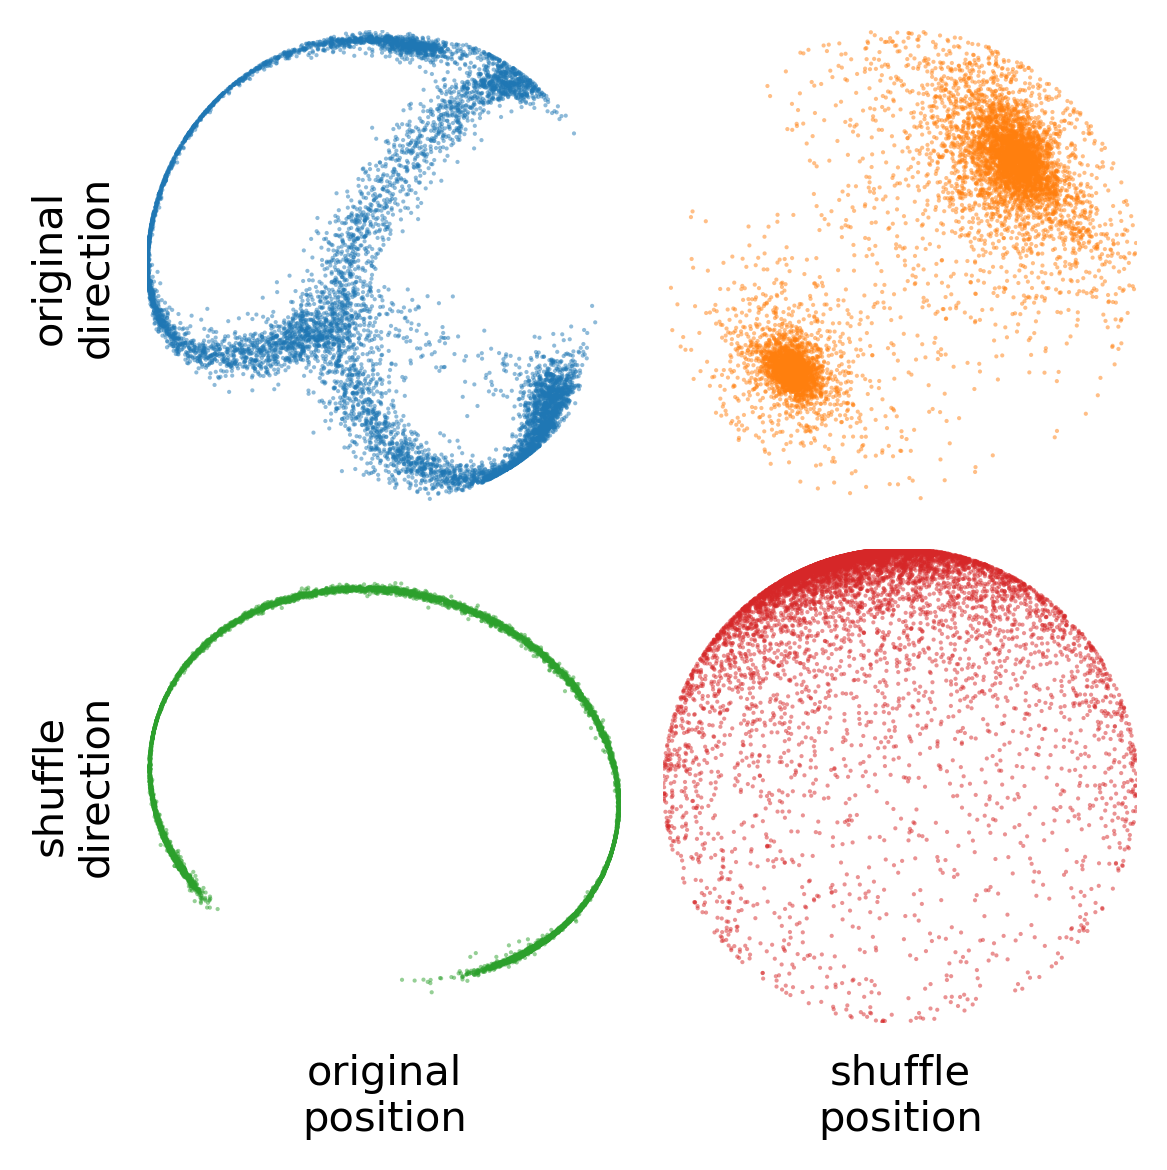

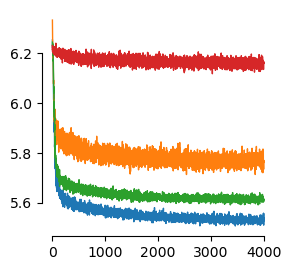

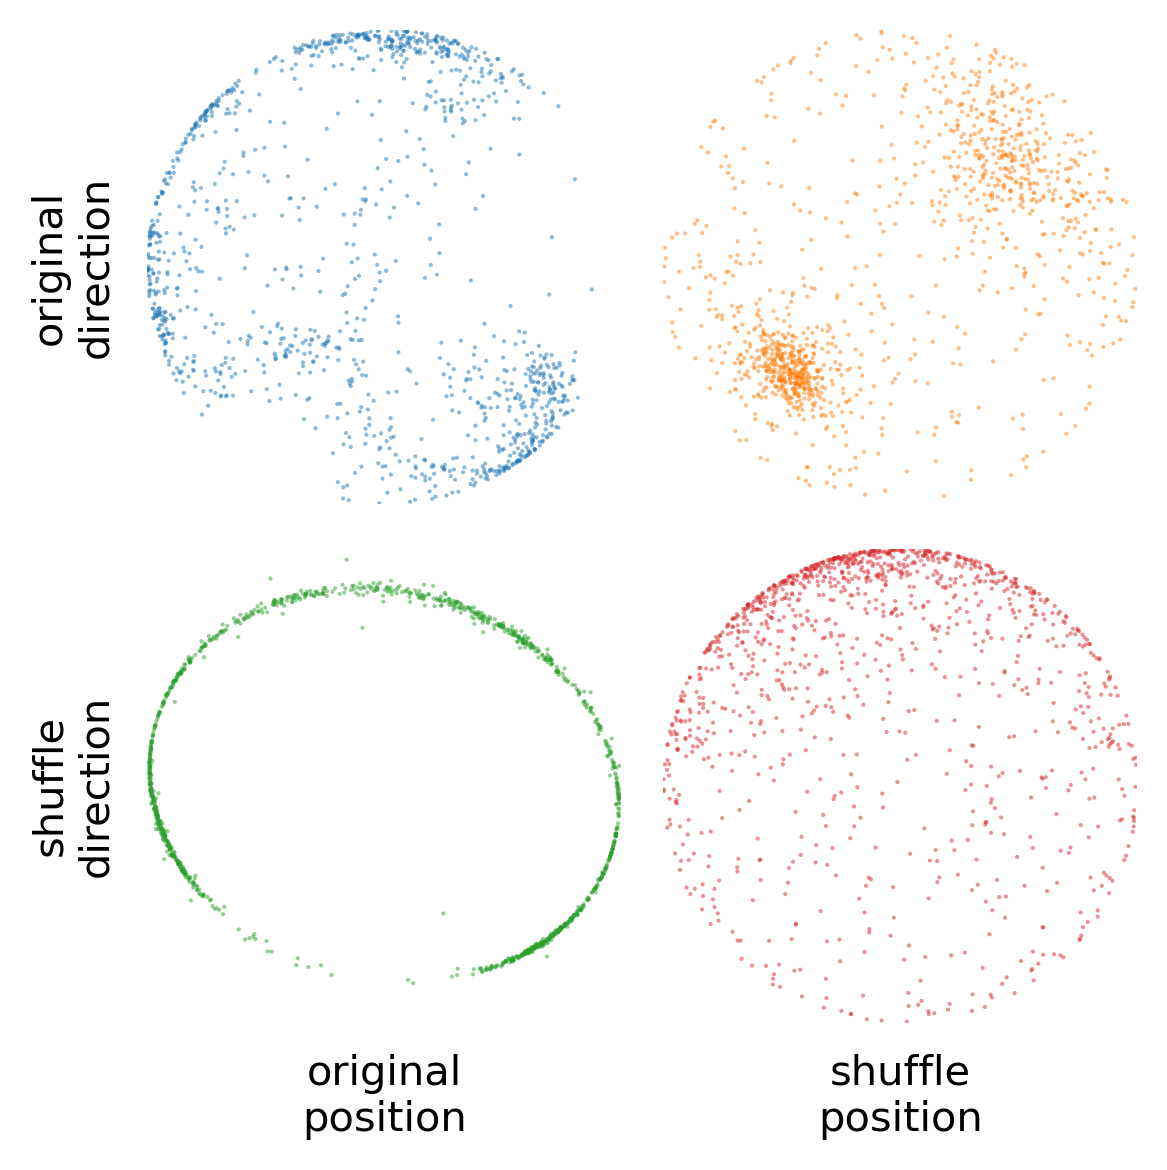

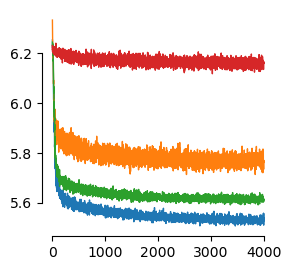

In [88]:
import itertools

n = 0


    
def plot_grid(files, *, split):

  keys = []
  options = ('original', 'shuffle')

  fig, axes = plt.subplots(2, 2, figsize = (4, 4), dpi = 300)

  for ax, (key1, key2) in zip(axes.flatten(), itertools.product(options,options)):

    dim = 3
    
    key = (key1, key2, 'discrete', dim, split)
    if key not in files:
      key = (key1, key2, 'continuous', dim, split)
    emission = files[key]
    
    keys.append(key)

    scatter(*emission[:, [1,2]].T, ax = ax)
    apply_style(ax)

  for i in range(len(options)):
    axes[-1, i].set_xlabel(options[i] + '\nposition')
    axes[i, 0].set_ylabel(options[i] + '\ndirection')

  plt.tight_layout()
  
  return keys
  
keys = plot_grid(files, split = 'train')
plt.show()
loss_curve_plot(keys)
plt.show()
n = 0
keys = plot_grid(files, split = 'test')
plt.show()
loss_curve_plot(keys)
plt.show()

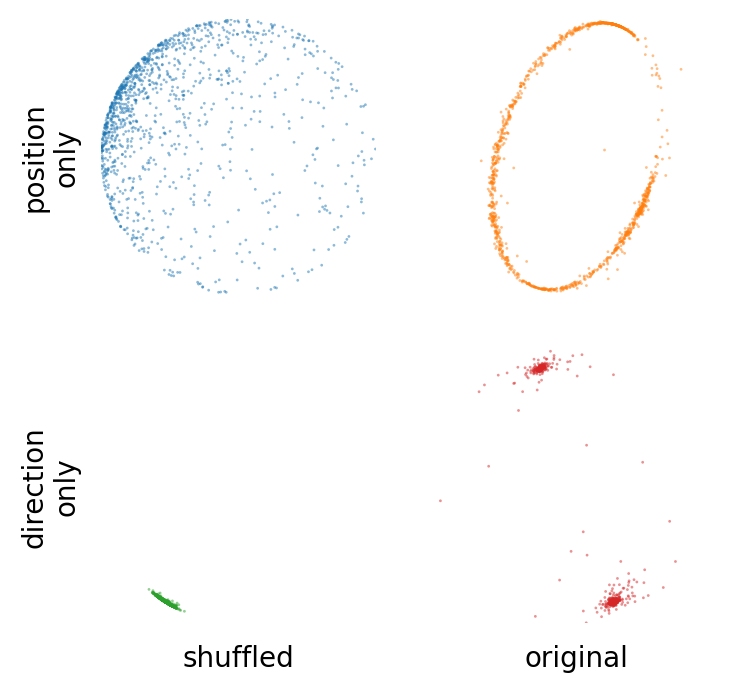

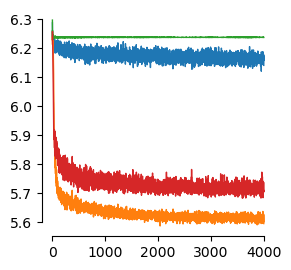

In [90]:
n = 0
fig, axes = plt.subplots(2, 2, figsize = (4, 4), dpi = 200)

options = ('shuffle', 'original')
options = itertools.chain.from_iterable((
  itertools.product(('none',), options),
  itertools.product(options, ('none',))
))
options = list(options)

keys = []
for ax, (key1, key2) in zip(axes.flatten(), options):
  dim = 3
  split = 'test'
  key = (key1, key2, 'mixed', dim, split)
  if key not in files:
    key = (key1, key2, 'continuous', dim, split)
  if key not in files:
    key = (key1, key2, 'discrete', dim, split)
  emission = files[key]
  scatter(*emission[:, [0,2]].T, ax = ax)
  apply_style(ax)
  keys.append(key)
  
axes[1,0].set_xlabel('shuffled')
axes[1,1].set_xlabel('original')
axes[0,0].set_ylabel('position\nonly')
axes[1,0].set_ylabel('direction\nonly')

plt.show()

loss_curve_plot(keys)
plt.show()